# 1.) Import an asset price from Yahoo Finance

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 551.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 3.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
  

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("MSFT", start="1990-01-01", end="2023-02-10")

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []
#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 4
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train_val = train_data[i, 0]
    if y_train_val > 0:
      y_train.append(1)
    else:
      y_train.append(0)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6668/6668 [==============================] - 32s 4ms/step - loss: 0.2502
Epoch 2/3
6668/6668 [==============================] - 28s 4ms/step - loss: 0.2501
Epoch 3/3
6668/6668 [==============================] - 29s 4ms/step - loss: 0.2502


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[['Close']].pct_change().dropna())[training_data_len:, :]

for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

53/53 [==============================] - 1s 3ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [ ]:
# Convert y_train and y_test to binary form
y_train_binary = np.where(y_train > 0,1,0)
y_test_binary = np.where(y_test > 0,1,0)

# Make predictions
predictions = model.predict(x_test)
predictions_binary = np.where(predictions > 0,1,0)

53/53 [==============================] - 0s 5ms/step


In [ ]:
# Calculate in-sample accuracy and random walk assumption accuracy
in_acc = accuracy_score(y_train_binary[input_size:], np.where(y_train_binary[input_size-1:-1] == 1,1,0))
in_rw_acc = accuracy_score(y_train_binary[input_size:], np.where(y_train_binary[input_size-1:-1] == 0,1,0))

# Calculate out-of-sample accuracy and random walk assumption accuracy
out_acc = accuracy_score(y_test_binary, predictions_binary)
out_rw_acc = accuracy_score(y_test_binary[input_size:], np.where(y_test_binary[input_size-1:-1] == 0,1,0))

<BarContainer object of 4 artists>

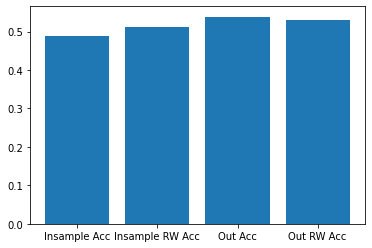

In [ ]:
# plot the accuracy
from matplotlib import pyplot as plt
plt.bar(["Insample Acc","Insample RW Acc","Out Acc","Out RW Acc"],[in_acc, in_rw_acc, out_acc, out_rw_acc])

# 4.) Plot in and out of sample accuracy

In [ ]:
#skip

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

From Q3, we cansee that the accuracy is around 0.5, while randorm walk performs higher accuracy with in sample sata, the RNN model performs higher accuracy with out of sample data.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [1]:
#skip